In [60]:
import atoti as tt

In [61]:
session = tt.Session(
    user_content_storage=".content",
    port=9095,
    java_options=["-Xms1G", "-Xmx10G"]
)

Closing existing "Unnamed" session to create the new one.


In [32]:
db_name = "Project1"
db_user = "postgres"
db_password = "postgres"  
db_host = "localhost"  
db_port = "5432"

In [33]:
jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

In [34]:
jdbc_url

'jdbc:postgresql://localhost:5432/Project1?user=postgres&password=postgres'

In [62]:
facttest = session.read_sql(
    "SELECT * FROM olympics",
    keys=["factid"],
    table_name="factTable",
    url=jdbc_url,
)

In [64]:
facttest.head()

,year,country,bronze,gold,silver,code,depression,schizophrenia,bipolar,eatingdisorder,anxiety
factid,,,,,,,,,,,
13,1992,Denmark,5,1,2,DNK,774.02527,136.84724,203.96803,87.71734,460.94922
5,1992,Bahamas,1,0,0,BHS,527.91235,182.78604,195.25314,60.941833,406.74252
25,1992,Italy,14,10,11,ITA,676.9239,189.44333,185.89877,111.49093,534.1591
33,1992,Mexico,0,0,1,MEX,533.24414,180.24562,198.24474,48.886414,274.3233
41,1992,Pakistan,1,0,0,PAK,688.96924,181.0899,83.053276,21.568497,315.66284


In [65]:
medals = session.read_sql(
    "SELECT * FROM medalsnew",
    keys=["id"],
    table_name="Medals",
    url=jdbc_url)

In [66]:
countries = session.read_sql(
    "SELECT * FROM countries",
    keys=["country"],
    table_name="Countries",
    url=jdbc_url)

In [67]:
illness = session.read_sql(
    "SELECT * FROM mentalillness",
    keys=["code","year"],
    table_name="Illness",
    url=jdbc_url)

In [68]:
facttest.join(countries, facttest["country"] == countries["country"])

In [69]:
facttest.join(medals, facttest["country"] == medals["country"])

In [70]:
facttest.join(illness, (facttest["code"] == illness["code"]) & (facttest["year"] == illness["year"]))

In [71]:
session.tables.schema

```mermaid
erDiagram
  "Countries" {
    _ String PK "country"
    _ String "continent"
  }
  "Illness" {
    _ String "country"
    _ String PK "code"
    _ int PK "year"
    nullable double "depression"
    nullable double "schizophrenia"
    nullable double "bipolar"
    nullable double "eatingdisorder"
    nullable double "anxiety"
  }
  "factTable" {
    _ int PK "factid"
    nullable int "year"
    _ String "country"
    nullable int "bronze"
    nullable int "gold"
    nullable int "silver"
    _ String "code"
    nullable double "depression"
    nullable double "schizophrenia"
    nullable double "bipolar"
    nullable double "eatingdisorder"
    nullable double "anxiety"
  }
  "Medals" {
    nullable int "year"
    _ String "medal"
    _ String "country"
    _ String "code"
    _ int PK "id"
  }
  "factTable" }o--o| "Illness" : "(`year` == `year`) & (`code` == `code`)"
  "factTable" }o--o| "Countries" : "`country` == `country`"
  "factTable" }o..o{ "Medals" : "`country` == `country`"
```


In [72]:
testcube = session.create_cube(facttest)

In [89]:
testcube.measures['total.SUM'] = testcube.measures['gold.SUM'] + testcube.measures['silver.SUM'] + testcube.measures['bronze.SUM']

In [90]:
testcube

In [76]:
hierarchies, levels, measures = testcube.hierarchies, testcube.levels, testcube.measures

In [77]:
hierarchies

{('factTable', 'code'): <atoti.hierarchy.Hierarchy object at 0x7efe94fdb2b0>, ('Medals', 'code'): <atoti.hierarchy.Hierarchy object at 0x7efe94fdafe0>, ('Countries', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7efe94fdacb0>, ('Medals', 'id'): <atoti.hierarchy.Hierarchy object at 0x7efe94fd9a80>, ('Medals', 'medal'): <atoti.hierarchy.Hierarchy object at 0x7efe961b46a0>, ('Illness', 'country'): <atoti.hierarchy.Hierarchy object at 0x7efebc4d6e90>, ('factTable', 'factid'): <atoti.hierarchy.Hierarchy object at 0x7efe94fdac20>, ('factTable', 'country'): <atoti.hierarchy.Hierarchy object at 0x7efe94e20af0>}

In [91]:
testcube.query(measures["total.SUM"], levels=[levels['Illness','country','country']])[1:20]

,total.SUM
country,
Algeria,15
Argentina,36
Armenia,14
Australia,347
Austria,161
Azerbaijan,43
Bahamas,12
Bahrain,3
Barbados,1


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
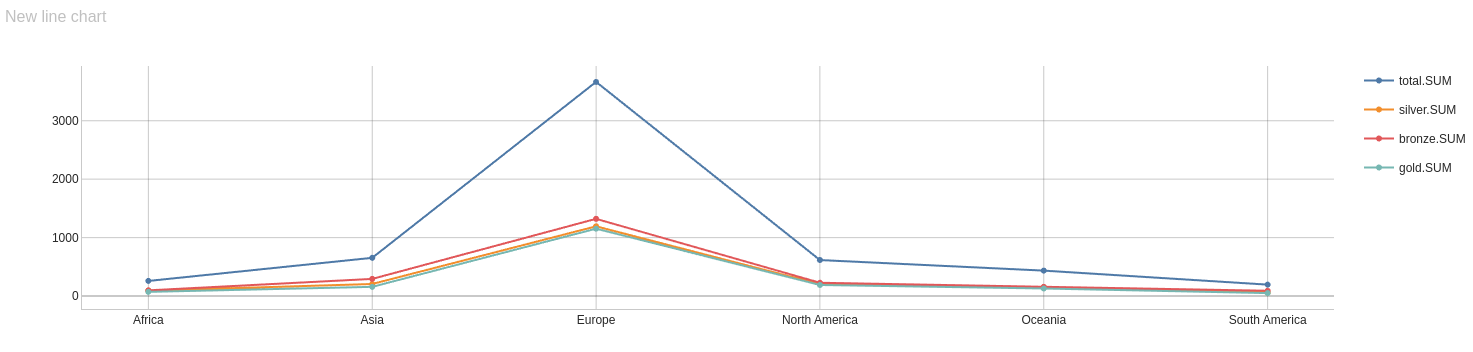

In [92]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
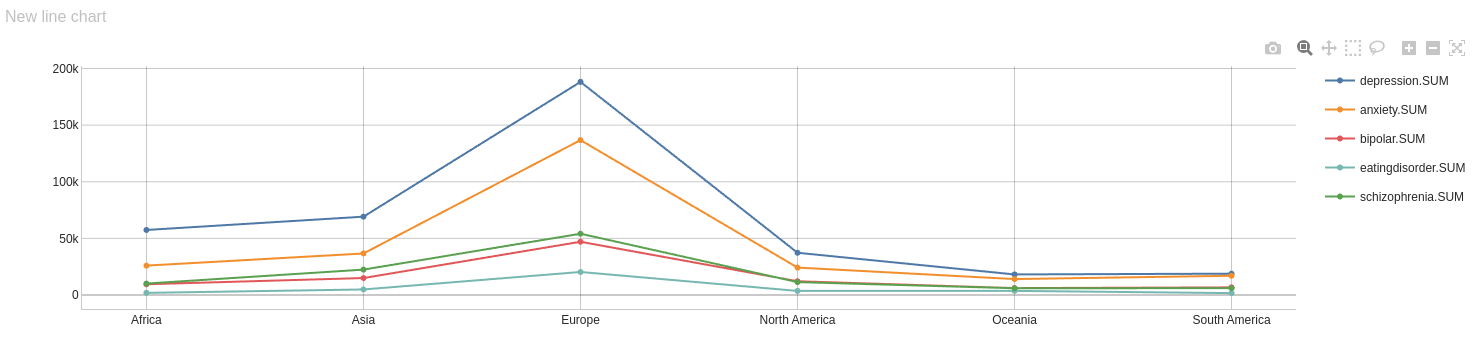

In [87]:
session.widget